### Data loading and cleaning (if necessary)



Task 0a: Set up libraries and function

In [2]:
# Load all libraries
import os
from requests import get
from urllib.parse import urlparse
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
from shapely.geometry import Polygon, MultiPolygon

In [3]:
# Function to download files from remote
def cache_data(src:str, dest:str) -> str:
    """
    Create a folder to store file from URL.
    If folder doesn't already exists, then create one, before writing the file.

    src : URL
    dest : location on local drive
    
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename as path
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

Task 0b: Load in CSV files and spatial objects

In [4]:
# Define paths
ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path
spath_db = 'https://www.dropbox.com/scl/fi/' # source path for dropbox

In [5]:
# Read in airbnb, crime, and lsoa stats files. https://www.dropbox.com/home/casa/casa_fsds_cheers
crime = pd.read_csv(cache_data(spath_db + 'y89gnm2yuqd0o83i060se/metrocrime_1020_0923.csv?rlkey=wtjfwd18dhsgzvt5gkspomfrh&dl=1', ddir),low_memory=False)
listings = pd.read_csv(cache_data(spath_db + '0v2xl5j4l2pvkxfolj5d0/london_listings_nov23.csv.gz?rlkey=feqrd33xwp8zdps2pqa9qzhao&dl=1', ddir),compression='gzip',low_memory=False)
lsoa_stat = pd.read_csv(cache_data(spath_db + 'akrhjcijbzmxdxrnar8ui/lsoa-data.csv?rlkey=mtivynogrr9w17950ur0vpa3z&dl=1', ddir), low_memory=False,encoding='ISO-8859-1')

Found data/metrocrime_1020_0923.csv locally!


Found data/london_listings_nov23.csv.gz locally!
Found data/lsoa-data.csv locally!


In [6]:
# Convert to geodataframes crime incidents, remove invalid geometries
crime = gpd.GeoDataFrame(crime, geometry=gpd.points_from_xy(crime['Longitude'], crime['Latitude']),crs='EPSG:4326')
crime = crime[~crime.geometry.is_empty] # From 3306145 rows to 3248648 rows after filtering out no geometry
crime = crime[crime['Month'].isin(['2023-09','2023-08','2023-07'])]  # From 3248648 rows to 287494 rows after filtering only 3 months in 2023
print(f'The crime dataset has {crime.shape[0]} rows and {crime.shape[1]} columns.')

# Convert to geodataframes listins, remove invalid geometries
listings = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings['longitude'], listings['latitude']), crs='EPSG:4326')
listings = listings[~listings.geometry.is_empty] # 87946 rows, no change
print(f'The listings dataset has {listings.shape[0]} rows and {listings.shape[1]} columns.')

# Clean up lsoa_stat
lsoa_stat = lsoa_stat.dropna() # 4835 rows
print(f'The lsoa_stat dataset has {lsoa_stat.shape[0]} rows and {lsoa_stat.shape[1]} columns.')

The crime dataset has 287494 rows and 14 columns.
The listings dataset has 87946 rows and 76 columns.
The lsoa_stat dataset has 4835 rows and 277 columns.


In [7]:
# Read in shapefiles
water = gpd.read_file(cache_data(spath+'Water.gpkg?raw=true', ddir))
green = gpd.read_file(cache_data(spath+'Greenspace.gpkg?raw=true', ddir))
boros = gpd.read_file(cache_data(spath+'Boroughs.gpkg?raw=true', ddir))
lsoa = gpd.read_file(cache_data(spath_db+'hda7eykjtjp760s1u4z05/LSOA_Dec_2021_Boundaries_Generalised.geojson?rlkey=9qj5zdxslgxpjshx41988oez1&dl=1', ddir))
print('Done.')

Found data/Water.gpkg locally!
Found data/Greenspace.gpkg locally!
Found data/Boroughs.gpkg locally!
Found data/LSOA_Dec_2021_Boundaries_Generalised.geojson locally!
Done.


Task 0c: Transformation + trim data to Greater London's confines

In [8]:
# Reproject everything to British National Grid
water = water.to_crs('epsg:27700')
green = green.to_crs('epsg:27700')
boros = boros.to_crs('epsg:27700')

lsoa = lsoa.to_crs('epsg:27700')
crime = crime.to_crs('epsg:27700')
listings = listings.to_crs('epsg:27700')

In [9]:
crime.head()

,Unnamed: 0,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry
3016407,3016407,8a979919939eea103752c2950eb92f9eb7443620990015...,2023-07,Metropolitan Police Service,Metropolitan Police Service,-0.722136,50.781053,On or near Elbridge Crescent,E01031385,Arun 019A,Public order,Under investigation,NaN,POINT (490184.639 98721.079)
3016408,3016408,6b7edff80e38d9dd9c6606d0f148d6148b9c72d8e8df01...,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.853504,51.067862,On or near Ashford Road,E01024037,Ashford 014D,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (600019.670 133710.061)
3016409,3016409,4ac2b89b203b23df253093a60e76723b73201a63b9edf9...,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.878940,51.160888,On or near Nine Acres,E01023984,Ashford 015C,Other theft,Investigation complete; no suspect identified,NaN,POINT (601396.855 144121.924)
3016410,3016410,NaN,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.142112,51.589389,On or near A1112,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,POINT (548490.136 190010.716)
3016411,3016411,NaN,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.136416,51.584898,On or near Lawn Farm Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,POINT (548110.195 189499.804)


In [10]:
# [Takes 3-4 minutes to run] Crop to London boundaries
listings = listings[listings.geometry.within(boros.geometry.unary_union)]
lsoa = lsoa[lsoa['LSOA21CD'].isin(lsoa_stat['Lower Super Output Area'].unique())]
crime = crime[crime['LSOA code'].isin(lsoa_stat['Lower Super Output Area'].unique())]

(155000.0, 202000.0)

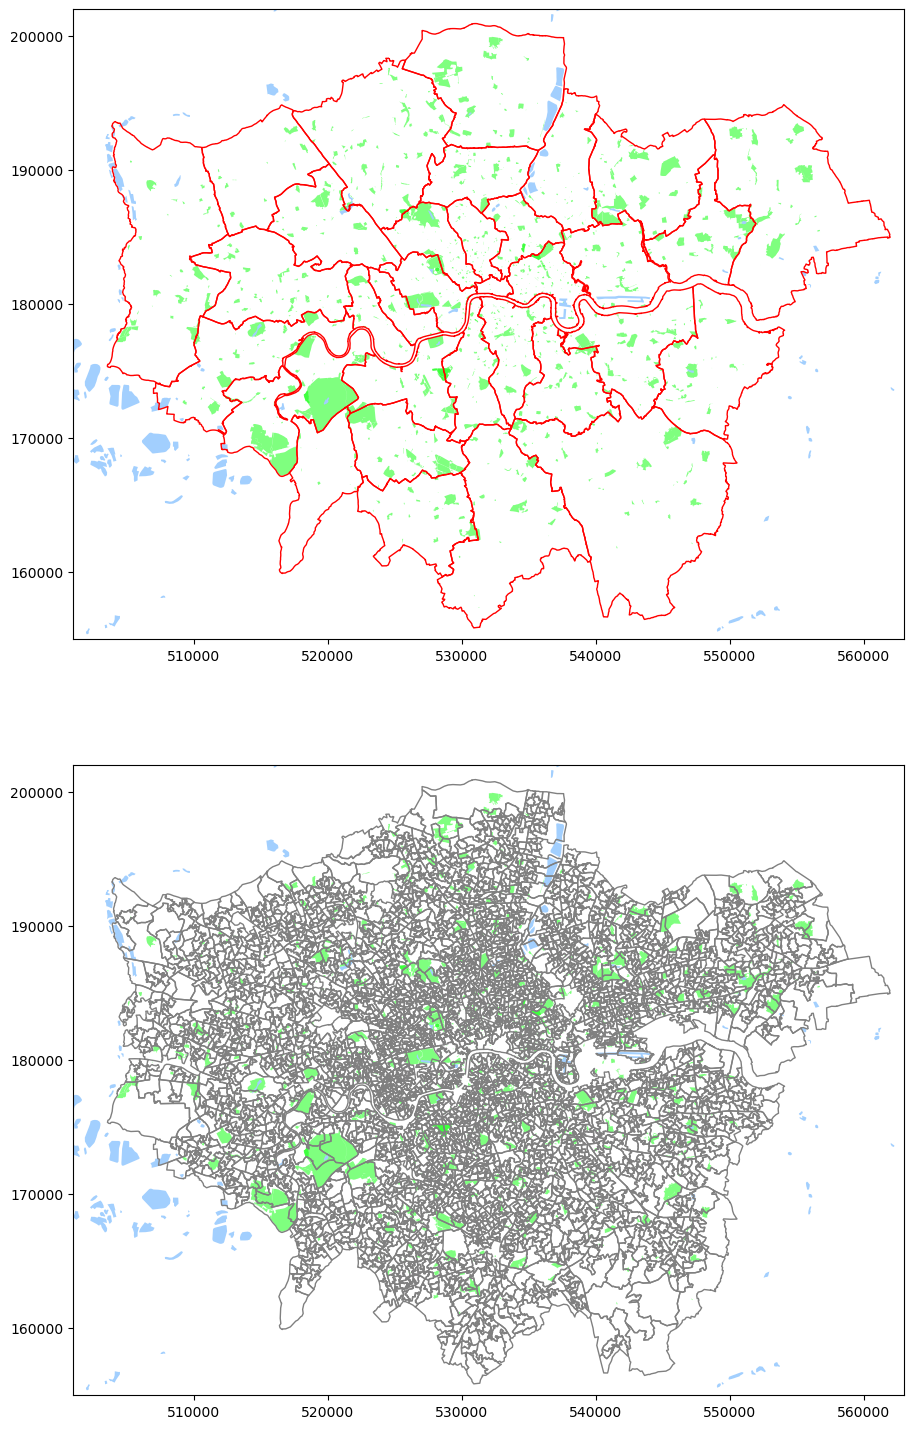

In [12]:
# Plot London map (empty)
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(24,18))

# Boroughs, water, greenspace
green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax1)
water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax1)
boros.plot(edgecolor='red', facecolor='None',ax=ax1)

# LSOA, water, greenspace
green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax2)
water.plot(edgecolor=None, facecolor='#a2cffe',ax=ax2)
lsoa.plot(edgecolor='grey', facecolor='None',ax=ax2)

# Set the x and y limits
ax1.set_xlim([501000, 563000])
ax1.set_ylim([155000, 202000])
ax2.set_xlim([501000, 563000])
ax2.set_ylim([155000, 202000])

Text(0.5, 1.0, 'Crimes in London, Jul-Sep 2023, Metropolitan Police')

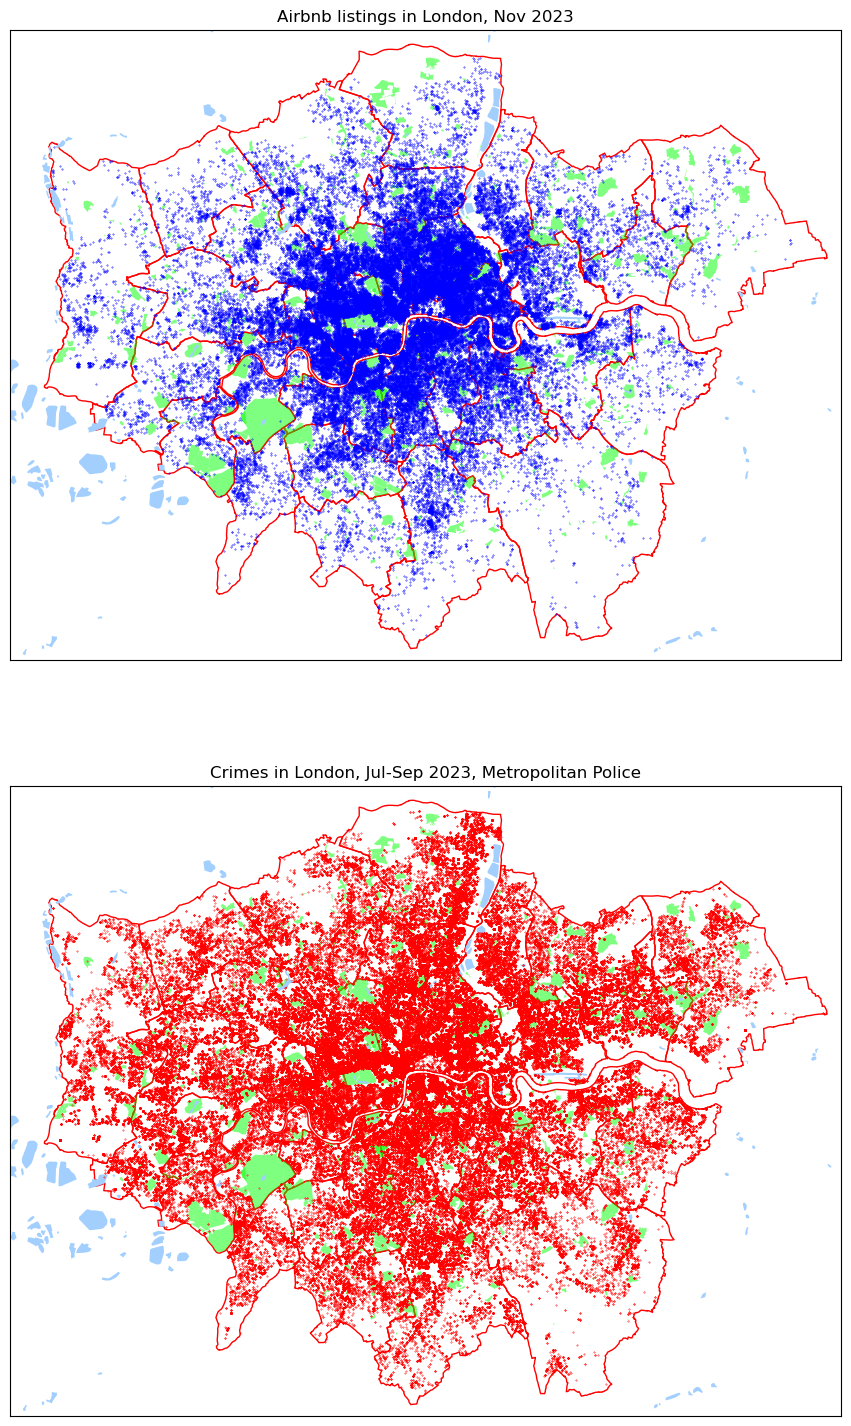

In [13]:
# Plot airbnb listings and crime incidents
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(24,18))

# Set the x and y limits
for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    boros.plot(edgecolor='red', facecolor='None',ax=ax)
    green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax)
    water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax)

listings.plot(ax=ax1, markersize=0.1,facecolor='blue')  
ax1.set_title('Airbnb listings in London, Nov 2023')

crime.plot(ax=ax2, markersize=0.1,facecolor='red')
ax2.set_title('Crimes in London, Jul-Sep 2023, Metropolitan Police')



In [14]:
# Clean crime data: outliers, and missing values, split into 2 types by severity
crime_serious = ['Burglary', 'Criminal damage and arson', 'Violence and sexual offences', 'Robbery', 'Theft from the person','Possession of weapons']
crime_minor = ['Anti-social behaviour', 'Public order', 'Vehicle crime', 'Drugs' , 'Shoplifting', 'Bicycle theft']

# Omit rows with Other Crime and Other Theft
crime = crime[~crime['Crime type'].isin(['Other theft','Other crime'])]
# Create a new column for crime type
crime['Severity'] = np.where(crime['Crime type'].isin(crime_serious), 'Serious', 'Minor')
crime.head()

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Unnamed: 0,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry,Severity
3016410,3016410,NaN,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.142112,51.589389,On or near A1112,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,POINT (548490.136 190010.716),Minor
3016411,3016411,NaN,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.136416,51.584898,On or near Lawn Farm Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN,POINT (548110.195 189499.804),Minor
3016412,3016412,a1c977633ca3340c10c4be26c0fcd037ad85936b16b481...,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.136513,51.588214,On or near Kingston Close,E01000027,Barking and Dagenham 001A,Burglary,Awaiting court outcome,NaN,POINT (548106.130 189868.726),Serious
3016413,3016413,b49e61583f711a53d568488cb5c5ebc4e1cd98be60f3d7...,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.145722,51.594296,On or near Providence Place,E01000027,Barking and Dagenham 001A,Criminal damage and arson,Under investigation,NaN,POINT (548724.164 190563.685),Serious
3016416,3016416,8c6153bb0d8aba4ba84eb27bef03e4c659bad78f917155...,2023-07,Metropolitan Police Service,Metropolitan Police Service,0.138830,51.583433,On or near Thatches Grove,E01000027,Barking and Dagenham 001A,Public order,Under investigation,NaN,POINT (548282.190 189341.784),Minor


['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']


/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

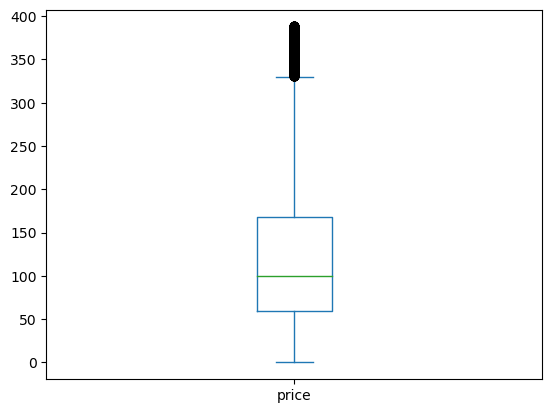

In [15]:
# Clean listings data: outliers, and missing values, split into 3 types by property type
print(listings.room_type.unique())
# Omit rows with Hotel room
listings = listings[~listings['room_type'].isin(['Hotel room'])]

# Transform price to float
if listings.price.dtype == 'O':
    listings.price = listings.price.str.replace('$','').str.replace(',','').astype(float).round(2)

# Trim outliers in terms of price based on interquartile range, because they are most likely they are not real listings
q1 = listings.price.quantile(0.25)
q3 = listings.price.quantile(0.75)
iqr = q3 - q1
listings = listings[(listings.price >= q1 - 1.5*iqr) & (listings.price <= q3 + 1.5*iqr)]
listings.price.plot.box()

### Descriptive statistics (Question #6 - 18 points)

*Objective:* 
Show the clustering of airbnb (by type), and crime incidents (by type). Show possible correlations between airbnb density and crime incidents
Approach: 

1. Split airbnb listing by 3 types (entire house/private room/shared room), and crime by 2 types (person vs property)
2. Plot out all the airbnb listings.
     - Heat map (KDE for each)
     - Descriptive statistics for each (LSOA min, max, mean, median)
3. Plot all the crime incidents, split by .
    - Heat map (KDE for each)
    - Descriptive statistics for each (LSOA min, max, mean, median)
4. Visual observation based on the heatmaps above where airbnb listings and crimes seem to overlap
5. Run correlations
-------------------------------------------------------------------------------

Task 1: Produce heat map for each type of airbnb listings

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

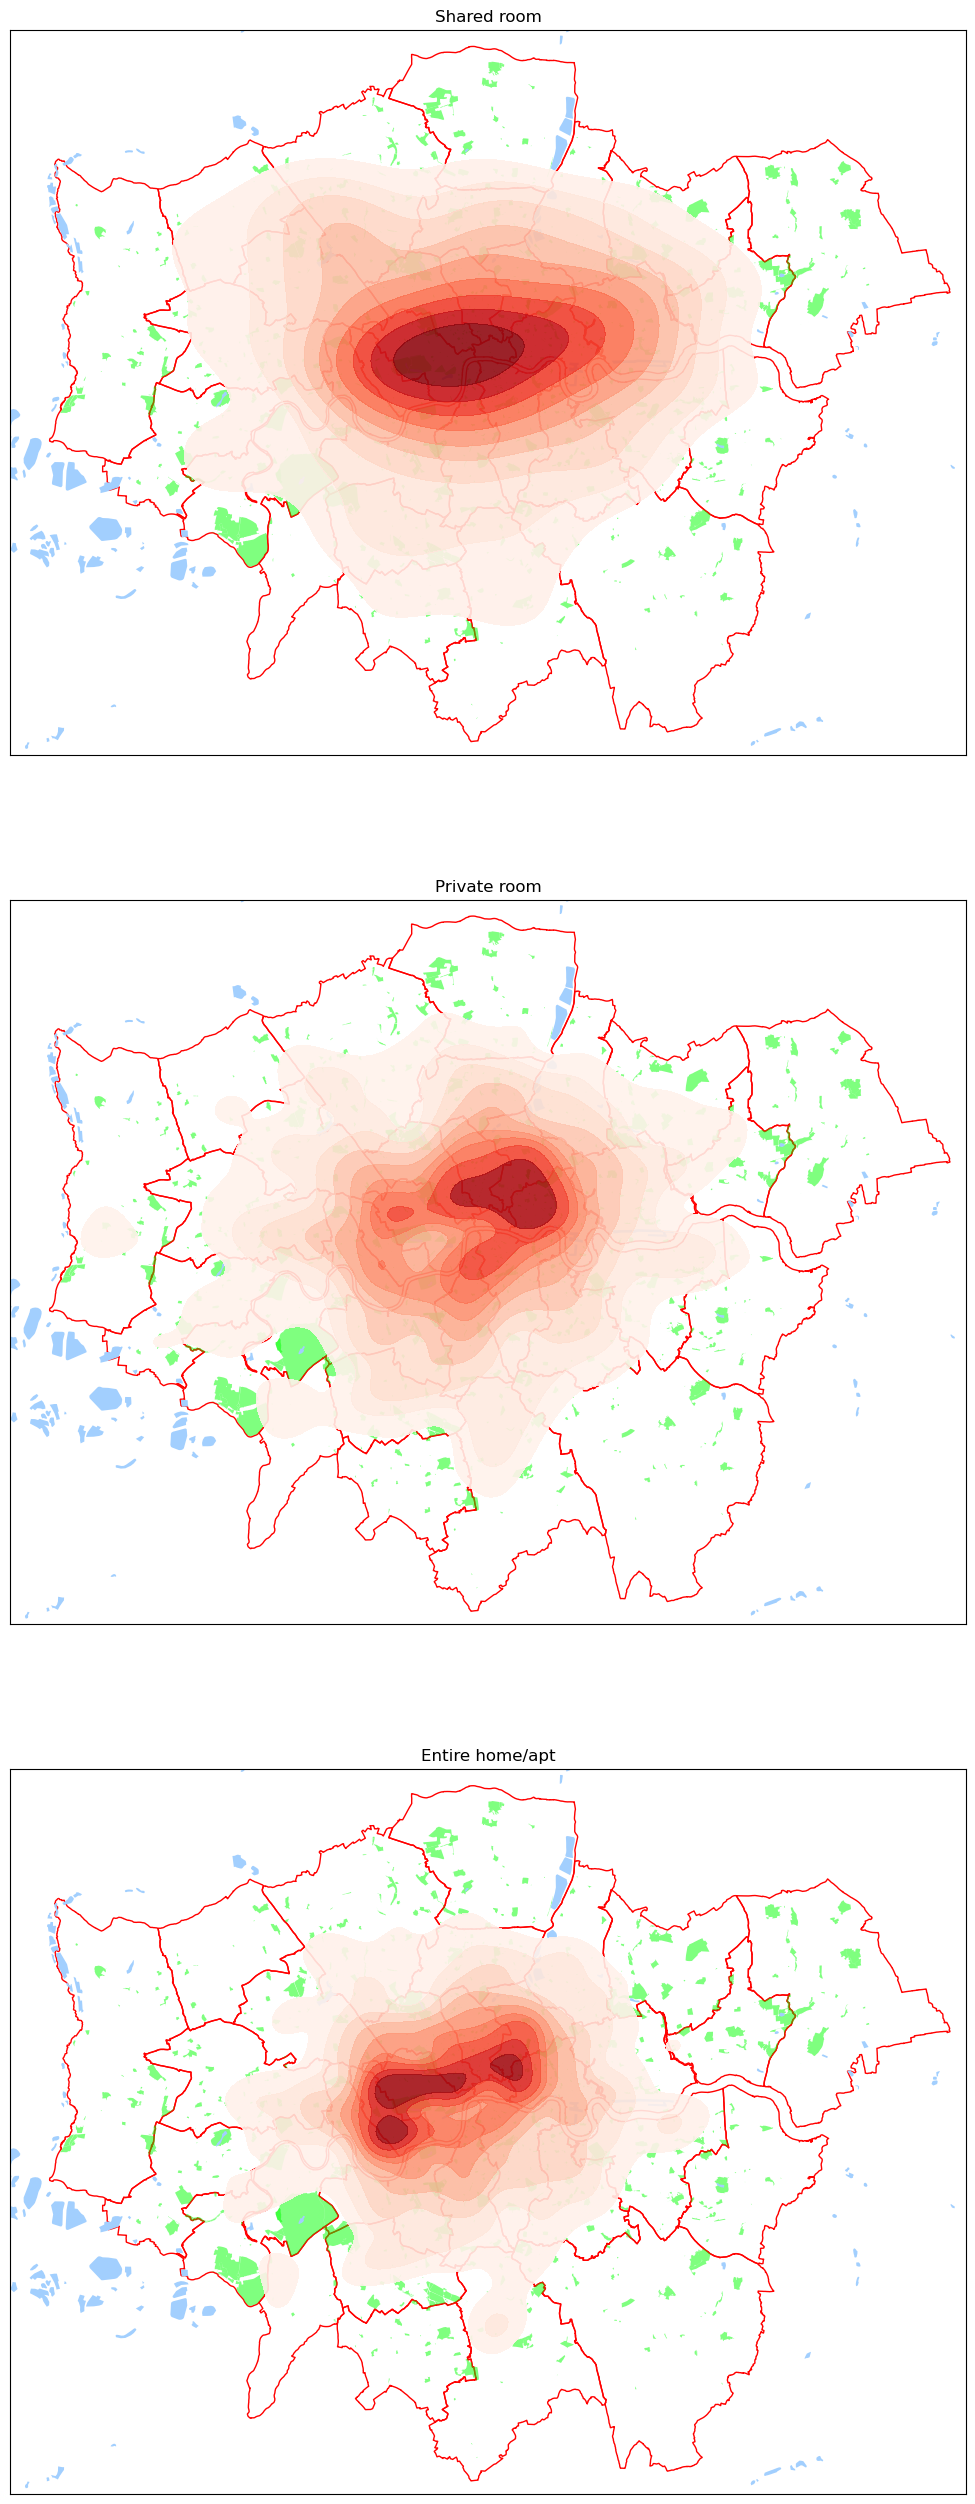

In [16]:
# kernel density estimation plot of listings for each room type on a map
# ['Private room' 'Entire home/apt' 'Shared room']

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(48,32))


for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    boros.plot(edgecolor='red', facecolor='None',ax=ax)
    green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax)
    water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax)


# Create thresholds
levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# Kernel Density Estimation

kde = sns.kdeplot(
    ax=ax1,
    x=listings[listings.room_type=='Shared room'].geometry.x,
    y=listings[listings.room_type=='Shared room'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

kde = sns.kdeplot(
    ax=ax2,
    x=listings[listings.room_type=='Private room'].geometry.x,
    y=listings[listings.room_type=='Private room'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

kde = sns.kdeplot(
    ax=ax3,
    x=listings[listings.room_type=='Entire home/apt'].geometry.x,
    y=listings[listings.room_type=='Entire home/apt'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

ax1.set_title('Shared room')
ax2.set_title('Private room')
ax3.set_title('Entire home/apt')

plt.show()


Task 2: Produce heat map for each type of crime

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

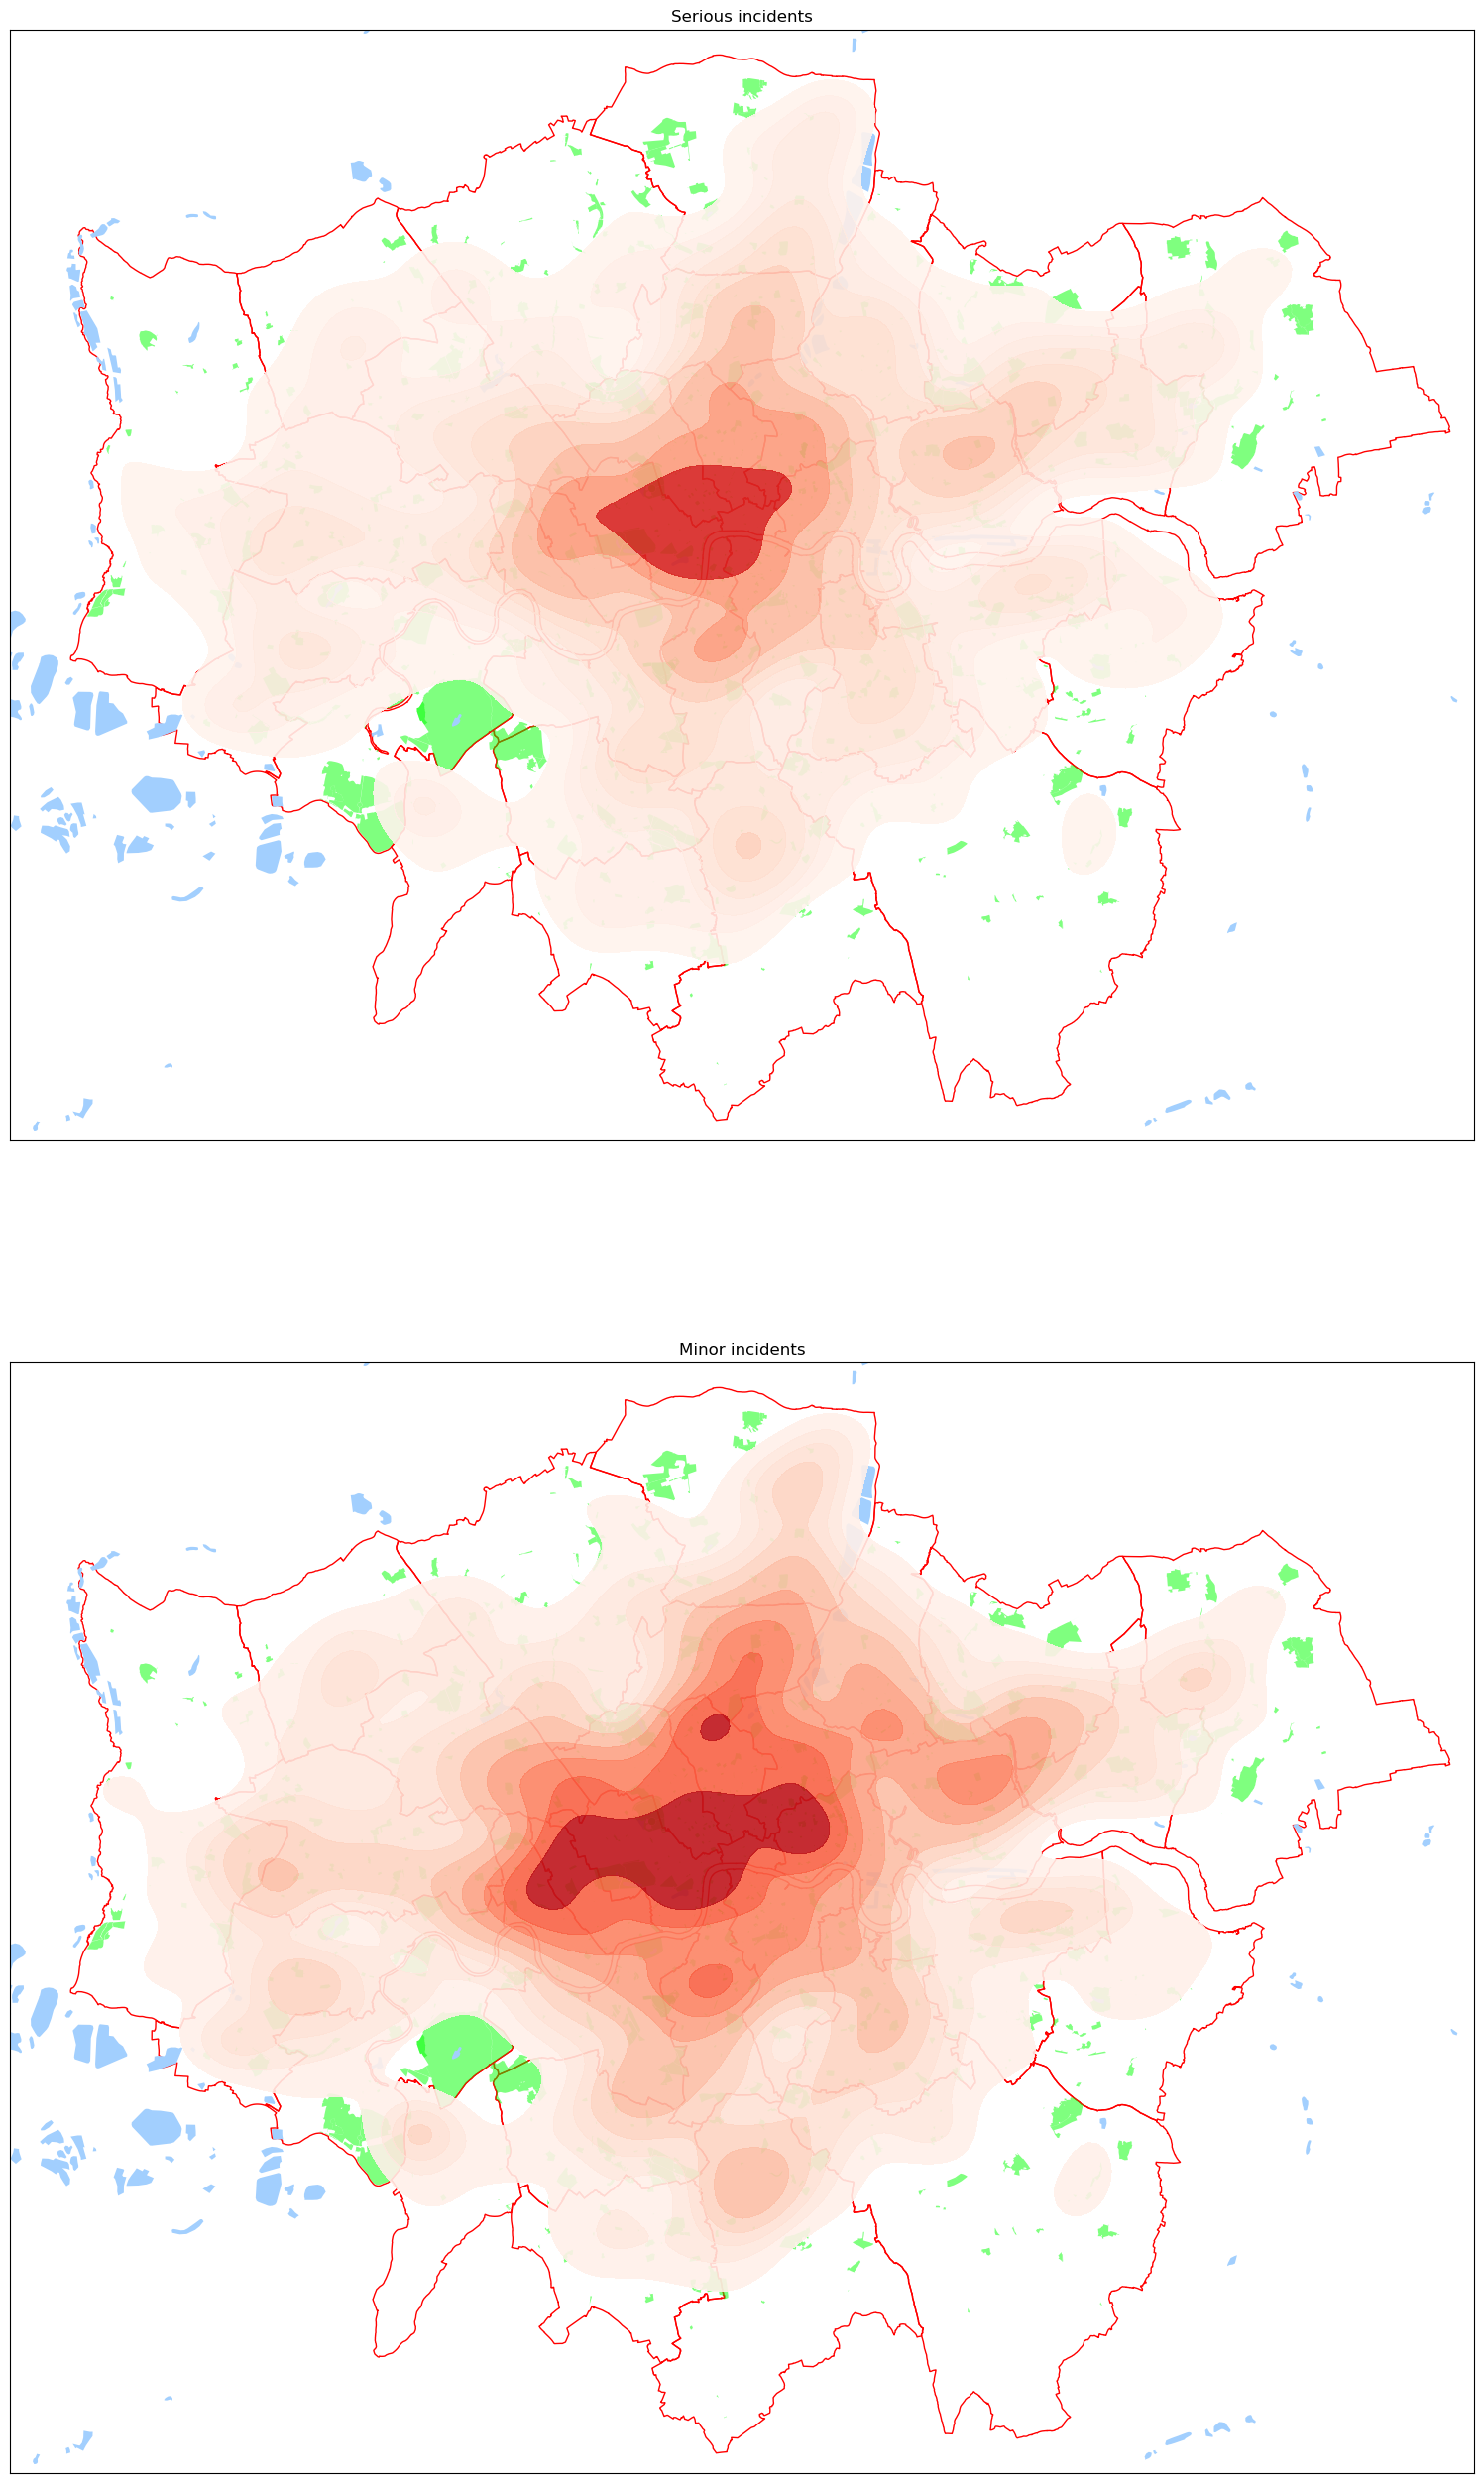

In [17]:
# kernel density estimation plot of crime for each type on a map
# ['Serious' 'Minor']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(48,32))

for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    boros.plot(edgecolor='red', facecolor='None',ax=ax)
    green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax)
    water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax)

# Create thresholds
levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# Kernel Density Estimation

kde = sns.kdeplot(
    ax=ax1,
    x=crime[crime['Severity']=='Serious'].geometry.x,
    y=crime[crime['Severity']=='Serious'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

kde = sns.kdeplot(
    ax=ax2,
    x=crime[crime['Severity']=='Minor'].geometry.x,
    y=crime[crime['Severity']=='Minor'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

ax1.set_title('Serious incidents')
ax2.set_title('Minor incidents')

plt.show()


Task 3: Visual observation based on the heatmaps above where airbnb listings and crimes seem to overlap

...

Task 4: Run correlations + spatial autocorrelation

In [39]:
# Spatial crime listings and lsoa, summarise by count
sjoin_lsoa = gpd.sjoin(crime, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['crime_count'] = lsoa['LSOA code'].map(count_dict) # map it back to lsoa

In [35]:
# Spatial join listings and lsoa, summarise by count
sjoin_lsoa = gpd.sjoin(listings, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['listing_count'] = lsoa['LSOA code'].map(count_dict) # map it back to lsoa

In [37]:
# Spatial join crime by severity and lsoa, summarise by count
for s in ['Serious','Minor']:
    sjoin_lsoa = gpd.sjoin(crime[crime['Severity']==s], lsoa_merge)
    count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
    lsoa_merge['crime_count_'+s] = lsoa_merge['LSOA code'].map(count_dict) # map it back to lsoa_merge

# Sptial join listings by room type and lsoa, summarise by count
for r in ['Shared room','Private room','Entire home/apt']:
    sjoin_lsoa = gpd.sjoin(listings[listings['room_type']==r], lsoa_merge)
    count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
    lsoa_merge['listing_count_'+r] = lsoa_merge['LSOA code'].map(count_dict) # map it back to lsoa_merge

In [40]:
lsoa_merge.head()

,OBJECTID,LSOA21CD,LSOA21NM,GlobalID,geometry,LSOA code,crime_count,listing_count,crime_count_Serious,crime_count_Minor,listing_count_Shared room,listing_count_Private room,listing_count_Entire home/apt
0,1,E01000001,City of London 001A,f1865556-4e62-48e3-a025-d93a40f15e46,"POLYGON ((532105.312 182010.574, 532162.491 18...",E01000001,NaN,16.0,NaN,NaN,1.0,5.0,10.0
1,2,E01000002,City of London 001B,83e78aad-ee05-44a5-a8d3-077de6ed4053,"POLYGON ((532634.497 181926.016, 532619.141 18...",E01000002,9.0,14.0,4.0,5.0,NaN,NaN,14.0
2,3,E01000003,City of London 001C,69c457df-229e-4446-9577-95ac1c9be694,"POLYGON ((532135.138 182198.131, 532158.250 18...",E01000003,3.0,16.0,3.0,NaN,NaN,4.0,12.0
3,4,E01000005,City of London 001E,d537d59f-237a-45ed-a514-b0ab2a93e510,"POLYGON ((533808.018 180767.774, 533649.037 18...",E01000005,30.0,99.0,14.0,16.0,NaN,20.0,79.0
4,5,E01000006,Barking and Dagenham 016A,8d0081fe-69e2-48ac-aaf9-fd270d60e339,"POLYGON ((545122.049 184314.931, 545271.849 18...",E01000006,27.0,7.0,14.0,13.0,NaN,6.0,1.0


In [ ]:
# Need to do Correlation matrix + Spatial Autocorelation to describe the relationship between crime and listings

[Explain the correlation between the number of listings and the number of crimes in each LSOA.] 300-400 words

### Inferring statistics (Question #7 - 45 points)

*Objective:* 
Show causation and infer recommendations

1. Step 1
2. Step 2
3. Step 3

*Notes:* 

- [From Kernel Density Estimation to Spatial Analysis In Python](https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b)
- [Airbnb and neighborhood crime: The incursion of tourists or the erosion of local social dynamics?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8279333/): "We find evidence that increases in Airbnb listings led to more violence in neighborhoods in later years. This result supports the notion that the prevalence of Airbnb listings erodes the natural ability of a neighborhood to prevent crime, but does not support the interpretation that elevated numbers of tourists bring crime with them."
-------------------------------------------------------------------------------